## 2D Paper Results

This code is set up to replicate the 2D examples from the paper. 

In [1]:
#If you have the mcd package installed, comment the two lines below. If running from the source code, uncomment them.
import sys
sys.path.append('../src/')

import decode_mcd
import decode_mcd.multi_objective_problem as MOP
from decode_mcd import data_package
from decode_mcd import design_targets
from decode_mcd import counterfactuals_generator

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

### Setting Up
First we build the validity function used in the example. It consists of four "arcs" and one circle. 

In [2]:
def validity(_x): #Validity function for the 2D case
    a = _x["X"] #Separate the two dimensions for clarity
    b = _x["Y"]
    fc = np.less(np.sqrt(np.power((a-0.3), 2) + np.power((b-0.3), 2)), 0.1) #Circle
    sc = np.less(np.power(np.power(np.power((a-b), 6)-1, 2) + np.power(np.power((a+b), 6)-1, 2), 2), 0.99) #Arcs
    return np.logical_or(fc, sc) #If points are in circle or arcs they are valid

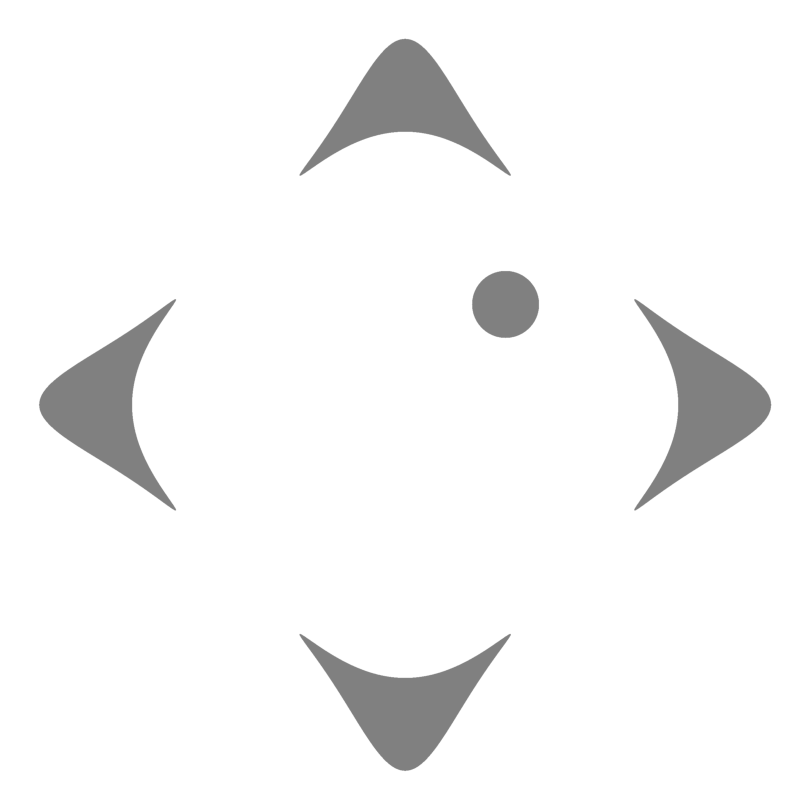

In [3]:
def plot_validity(validity, rangearr):
    xx, yy = np.mgrid[rangearr[0,0]:rangearr[0,1]:.001, rangearr[1,0]:rangearr[1,1]:.001]
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_df = pd.DataFrame(grid, columns = ["X", "Y"])
    Z = validity(grid_df)
    Z = np.array(Z)
    Z = Z.reshape(xx.shape)
    fig, ax = plt.subplots(1, 1, figsize=(5,5), dpi=200)
    img = ax.imshow(1-Z.T, cmap="gray", alpha=0.5, origin='lower', extent = rangearr.flatten())
    ax.axis('off')
    return ax

ranges = np.array([[-1.15, 1.15], [-1.15, 1.15]])

ax = plot_validity(validity, ranges)
plt.show()

Next, we sample the dataset, check the proportion that are valid, then visualize.

8.52% of the points are valid.


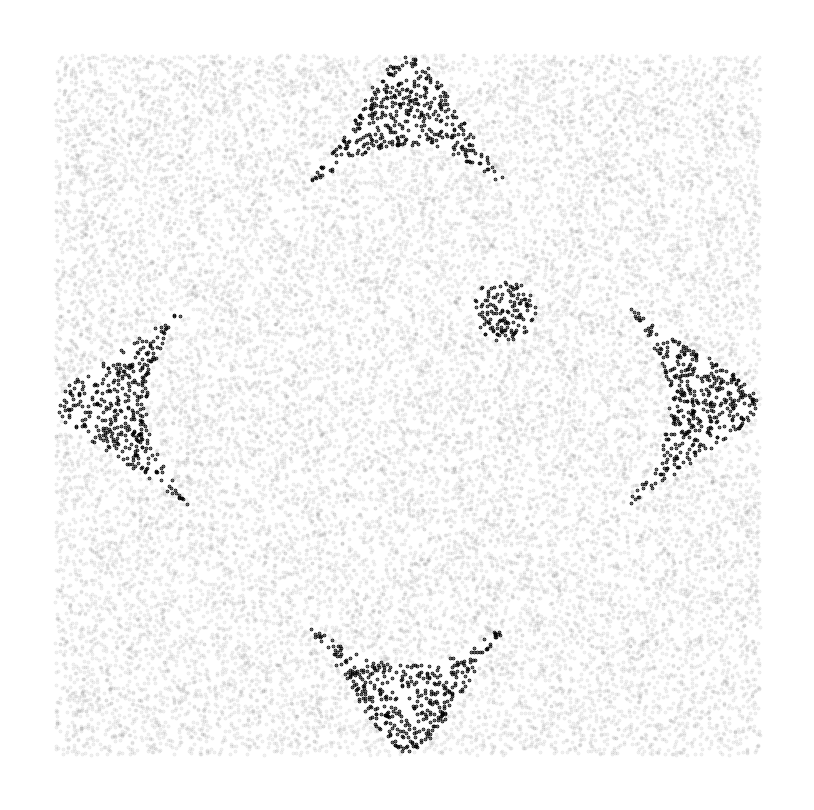

In [4]:
all_datapoints = np.random.rand(20000, 2) #Sample 10000 2D points
all_datapoints = all_datapoints*2.2-1.1 #Scale from -1.1 to 1.1
x_df = pd.DataFrame(all_datapoints, columns = ["X", "Y"])
validity_mask = validity(x_df)
y_df = pd.DataFrame(validity_mask, columns = ["O1"])
all_df = pd.concat([x_df, y_df], axis=1)

#Check the proportion that are valid
v = 100*np.mean(all_df["O1"])
print(f"{v:.2f}% of the points are valid.")

plt.figure(figsize=(5,5), dpi=200)
plt.scatter(all_df[all_df["O1"]]["X"], all_df[all_df["O1"]]["Y"], color="black", label="Valid", s=0.1)
plt.scatter(all_df[~all_df["O1"]]["X"], all_df[~all_df["O1"]]["Y"], color="gray", label="Invalid", s=0.1, alpha=0.2)
plt.axis("off")
plt.show()

### Running MCD
Let's run counterfactual search. :

In [5]:
from pymoo.core.variable import Real, Integer, Binary, Choice

#Specify a query point
query_x = np.array([[0,0]])

#Create a data_package instance
data = data_package.DataPackage(features_dataset=x_df,
                           predictions_dataset=y_df,
                           query_x=query_x,
                           design_targets=design_targets.DesignTargets([design_targets.ContinuousTarget(label="O1",
                                                                          lower_bound=0.9,
                                                                          upper_bound=1.1)]),
                           datatypes=[Real(bounds=(-1.1, 1.1)), Real(bounds=(-1.1, 1.1))])

#Create a problem instance
problem = MOP.MultiObjectiveProblem(data_package=data,
                                prediction_function=validity,
                                constraint_functions=[])

#Create a counterfactuals generator instance
generator = counterfactuals_generator.CounterfactualsGenerator(problem=problem,
                                     pop_size=500,
                                     initialize_from_dataset=True)

#Generate counterfactuals
generator.generate(n_generations=20)

20000 dataset entries found matching problem parameters
Initial population initialized from dataset of 20000 samples!
Training GA from 0 to 20 generations!
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        0 |      5 |  0.000000E+00 |  0.8233238338 |             - |             -
     2 |      500 |      8 |  0.000000E+00 |  0.000000E+00 |  1.0000000000 |         ideal
     3 |     1000 |     11 |  0.000000E+00 |  0.000000E+00 |  0.0239553776 |             f
     4 |     1500 |     12 |  0.000000E+00 |  0.000000E+00 |  0.0095420248 |             f
     5 |     2000 |     17 |  0.000000E+00 |  0.000000E+00 |  0.2256630431 |         nadir
     6 |     2500 |     19 |  0.000000E+00 |  0.000000E+00 |  0.0072156848 |             f
     7 |     3000 |     21 |  0.000000E+00 |  0.000000E+00 |  0.0074134924 |         ideal
     8 |     3500 |     22 |  0.000000E+00 |  0.000000E+00 |  0.0018228702 |             f
     9 |     4000 |     2

Let's create a function to visualize the generated counterfactuals. First, lets take a look at all the possible counterfactuals generated during optimization:

Scoring all counterfactual candidates!
Done! Returning CFs


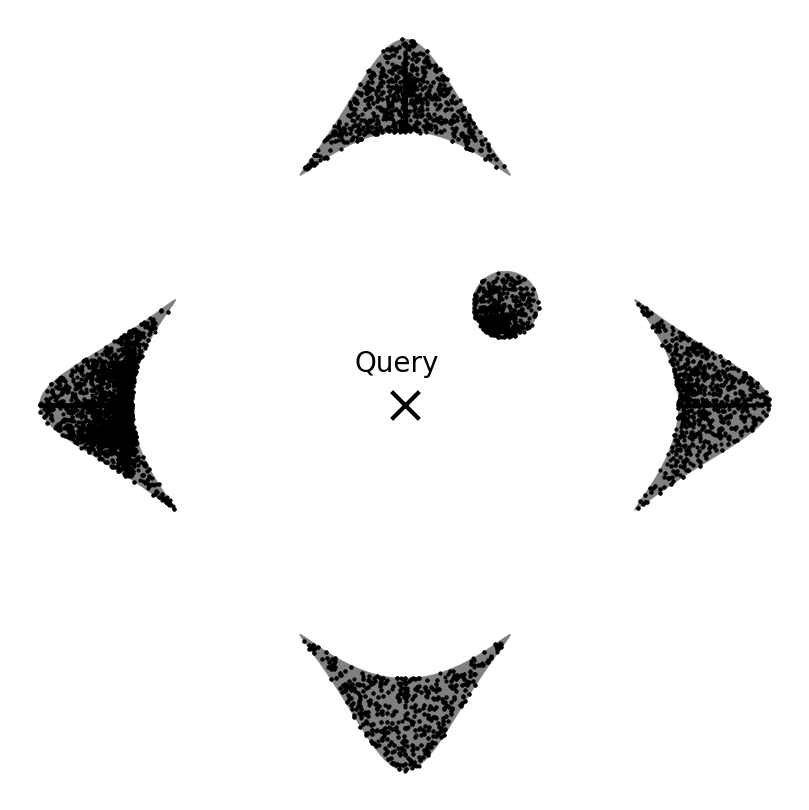

In [6]:
def plotcfs(validity, counterfactuals, query_x, rangearr, links=False):
    query = query_x[0]
    ax = plot_validity(validity, rangearr)
    ax.scatter(query[0], query[1], s=100, c="k", alpha = 1, marker="x")
    ax.annotate("Query", (query[0]-.15, query[0]+0.1))
    if not links: 
        ax.scatter(counterfactuals[:,0], counterfactuals[:,1], s=100, c="k", alpha = 1, marker=".")
        for i in range(np.shape(counterfactuals)[0]):
            ax.plot([query[0], counterfactuals[i,0]], [query[1], counterfactuals[i,1]],c = "k", linestyle="--", lw=1, alpha=0.5)
    else:
        ax.scatter(counterfactuals[:,0], counterfactuals[:,1], s=1, c="k", alpha = 1, marker=".")

_ = generator.sample_with_dtai(num_samples=1, gower_weight=1,avg_gower_weight=0.5, cfc_weight=0.5,diversity_weight=0.2) #Dummy sample to initialize all_cf_x

plotcfs(validity, generator._all_cf_x, query_x, ranges, links=True) #plot all counterfactuals

Let's first run a fairly balanced sampling. We should see that counterfactuals tend to be fairly spread out, change only one variable when possible, and lie close to the query when possible:

Scoring all counterfactual candidates!
Calculating diversity matrix!
Sampling diverse set of counterfactual candidates!
samples_index=[2237, 4036, 3066, 6197, 2739, 4444, 2350, 2813, 3481, 4386]
Done! Returning CFs


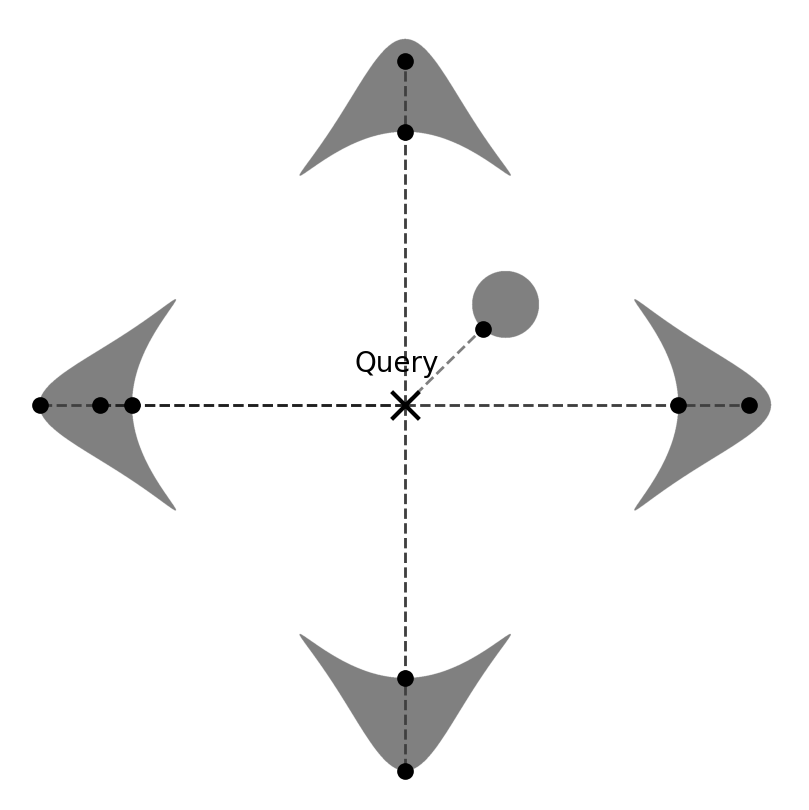

In [7]:
counterfactuals = generator.sample_with_dtai(num_samples=10, gower_weight=1,
                                             avg_gower_weight=0.5, cfc_weight=0.5,
                                             diversity_weight=0.2, include_dataset=False,
                                             num_dpp=10000)
plotcfs(validity, counterfactuals.values, query_x, ranges) #plot 10 counterfactuals

Next, we'll sample with high proximity weight. We expect most of the samples to come from the nearby circle:

Scoring all counterfactual candidates!
Calculating diversity matrix!
Sampling diverse set of counterfactual candidates!
samples_index=[440, 2615, 6197, 2739, 4607, 3361, 2905, 3650, 3292, 2902]
Done! Returning CFs


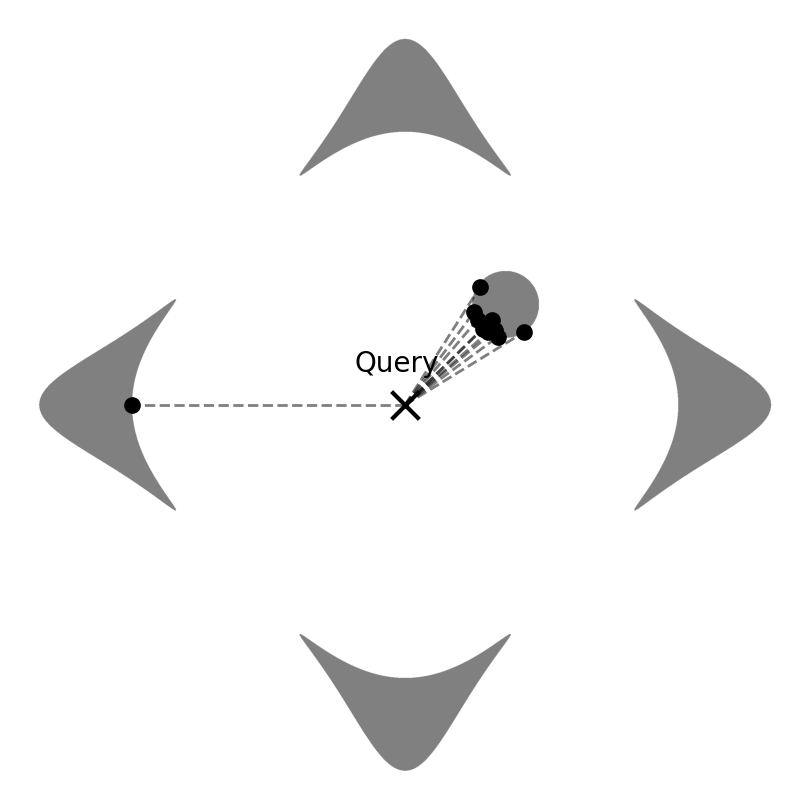

In [8]:
counterfactuals = generator.sample_with_dtai(num_samples=10, gower_weight=100,
                                             avg_gower_weight=0.5, cfc_weight=0.5,
                                             diversity_weight=0.2, include_dataset=False,
                                             num_dpp=10000)
plotcfs(validity, counterfactuals.values, query_x, ranges)

Next, sparsity. We should see that almost all the counterfactuals lie either directly above, below, left, or right of the query, changing only one variable:

Scoring all counterfactual candidates!
Calculating diversity matrix!
Sampling diverse set of counterfactual candidates!
samples_index=[2350, 4444, 1725, 2763, 2237, 6197, 4036, 3066, 3193, 4196]
Done! Returning CFs


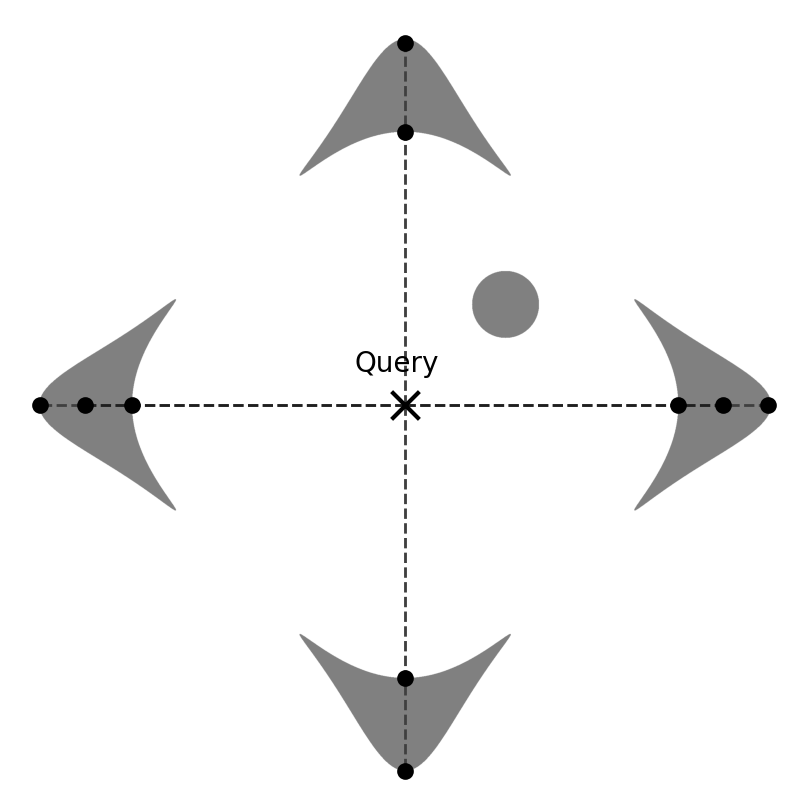

In [9]:
counterfactuals = generator.sample_with_dtai(num_samples=10, gower_weight=1,
                                             avg_gower_weight=0.5, cfc_weight=50,
                                             diversity_weight=0.2, include_dataset=False,
                                             num_dpp=10000)
plotcfs(validity, counterfactuals.values, query_x, ranges)

Next, Diversity. This should generate a diverse set of counterfactuals that are not necessarily very optimal. Note that MCD's greedy subset selection does not result in the exact optimal diverse subset, but nonetheless results in a very diverse subset:

Scoring all counterfactual candidates!
Calculating diversity matrix!
Sampling diverse set of counterfactual candidates!
samples_index=[2350, 4444, 1725, 2763, 4707, 142, 662, 869, 260, 1449]
Done! Returning CFs


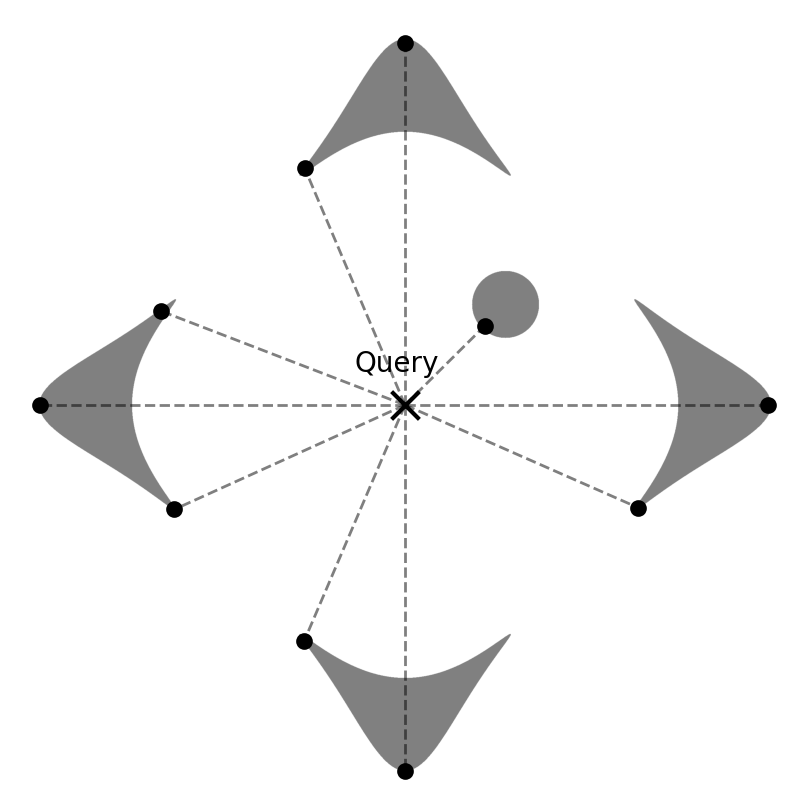

In [10]:
counterfactuals = generator.sample_with_dtai(num_samples=10, gower_weight=1,
                                             avg_gower_weight=0.5, cfc_weight=0.5,
                                             diversity_weight=20, include_dataset=False, 
                                             num_dpp=10000)
plotcfs(validity, counterfactuals.values, query_x, ranges)